In [1]:
import numpy as np
import math
from scipy.integrate import odeint
#import jax
#import jax.numpy as jnp
import sympy as sym
from sympy.matrices import Matrix
import matplotlib.pyplot as plt

In [2]:
# link masses
M1 = 3
M2 = 2
M3 = 1

# link lengths
LX = 0.1
LY = 0.1
L2 = 1
L3 = 0.5

# moments of inertia (base link doesn't rotate so don't need its inertia)
I2 = M2 * L2 ** 2 / 12
I3 = M3 * L3 ** 2 / 12

# inertia matrices
G1 = np.diag(np.array([M1, M1, 0]))
G2 = np.diag(np.array([M2, M2, I2]))
G3 = np.diag(np.array([M3, M3, I3]))

# gravity
G = 9.8

In [3]:

def manipulator(p,t):

    x1, dx1, θ2, dθ2, θ3, dθ3 = p
	
    #dq = np.array([[dx1],[dθ2],[dθ3]])
    dq = np.array([dx1,dθ2,dθ3])
    θ23 = θ2 + θ3

    m11 = M1 + M2 + M3
    m12 = -(0.5 * M2 + M3) * L2 * np.sin(θ2) - 0.5 * M3 * L3 * np.sin(θ23)
    m13 = -0.5 * M3 * L3 * np.sin(θ23)

    m22 = (
        (0.25 * M2 + M3) * L2 ** 2
        + 0.25 * M3 * L3 ** 2
        + M3 * L2 * L3 * np.cos(θ3)
        + I2
        + I3
    )
    m23 = 0.5 * M3 * L3 * (0.5 * L3 + L2 * np.cos(θ3)) + I3

    m33 = 0.25 * M3 * L3 ** 2 + I3

    M = np.array([[m11, m12, m13], [m12, m22, m23], [m13, m23, m33]])

    # Partial derivatives of mass matrix
    dMdx1 = np.zeros((3, 3))

    dMdθ2_12 = (
        -0.5 * M2 * L2 * np.cos(θ2) - M3 * L2 * np.cos(θ2) - 0.5 * M3 * L3 * np.cos(θ23)
    )
    dMdθ2_13 = -0.5 * M3 * L3 * np.cos(θ23)
    dMdθ2 = np.array([[0, dMdθ2_12, dMdθ2_13], [dMdθ2_12, 0, 0], [dMdθ2_13, 0, 0]])

    dMdθ3_12 = -0.5 * M3 * L3 * np.cos(θ23)
    dMdθ3_13 = -0.5 * M3 * L3 * np.cos(θ23)
    dMdθ3_22 = -M3 * L2 * L3 * np.sin(θ3)
    dMdθ3_23 = -0.5 * M3 * L2 * L3 * np.sin(θ3)
    dMdθ3 = np.array([
        [0, dMdθ3_12, dMdθ3_13],
        [dMdθ3_12, dMdθ3_22, dMdθ3_23],
        [dMdθ3_13, dMdθ3_23, 0],
    ])

    dMdq = np.zeros((3, 3, 3))
    dMdq[0, :, :] = dMdx1
    dMdq[1, :, :] = dMdθ2
    dMdq[2, :, :] = dMdθ3

    # This is equivalent to a set of for loops that fill out Γ such that
    # Γ[i, j, k] = dMdq[k, j, i] - 0.5*dMdq[i, j, k]
    Γ = dMdq.T - 0.5 * dMdq
    #C = np.ones(3)
    C = np.dot(dq, Γ) 
        
 
    g =np.array([
        0,
        (0.5 * M2 + M3) * G * L2 * np.cos(θ2) + 0.5 * M3 * L3 * G * np.cos(θ23),
        0.5 * M3 * L3 * G * np.cos(θ23),
    ])  

    IM = np.linalg.inv(M)
    A = (-1)*IM.dot(C+g)

    ddx1, ddθ2, ddθ3 = A

    return [dx1, ddx1, dθ2, ddθ2, dθ3, ddθ3]



In [4]:
max_t = 10.0
dt = 0.01
t = np.arange(0.0, max_t, dt)
x0 = [0.1, 0.0, 0.9*math.pi/2, 0.0, 0.9*math.pi/2, 0.0]
p = odeint(manipulator, x0, t)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

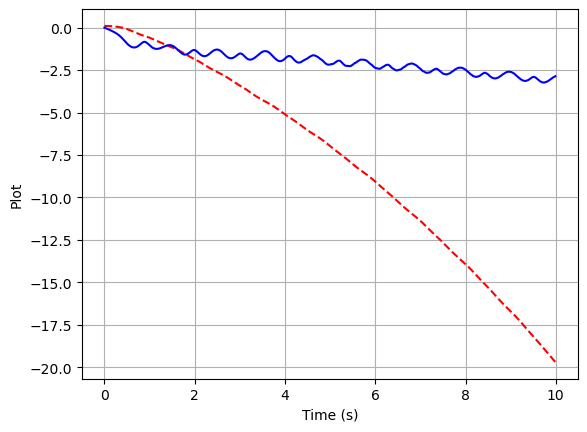

In [146]:
plt.plot(t,p[:,0],'r--')
plt.plot(t,p[:,1],'blue')
#plt.plot(t,p[:,5],'r+')
plt.xlabel('Time (s)')
plt.ylabel('Plot')
plt.grid(True)

In [ ]:
Γ = sym.permutedims(dMdq, (2, 1, 0)) - 0.5 * dMdq